# Note book for analysis CHEMBL target info

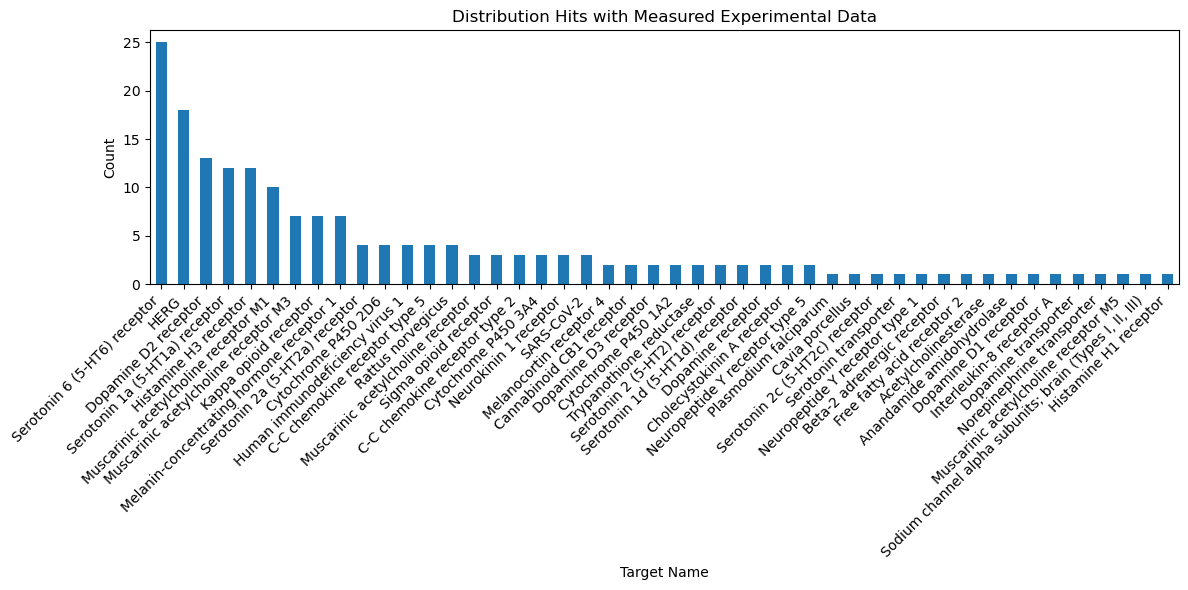

<Figure size 640x480 with 0 Axes>

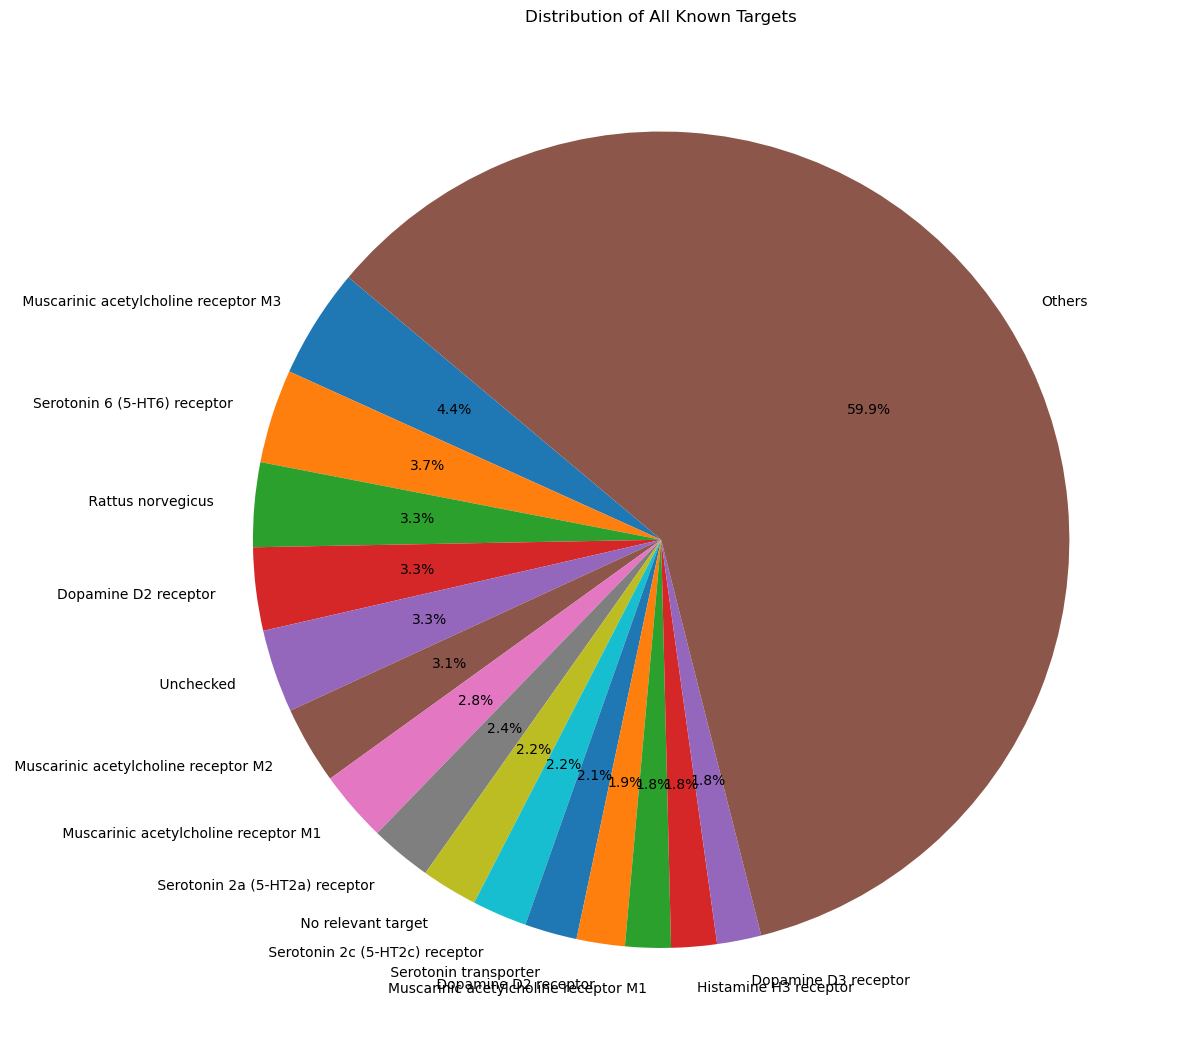

Total occurrences of 'Muscarinic' across all entries: 369
Number of entries containing 'Muscarinic': 156
Distribution of Muscarinic counts per entry:
all_known_targets
0    421
1     66
2     28
3     21
4     25
5     13
6      2
7      1
Name: count, dtype: int64
Top 20 rows with the lowest affinity_pred_value:
                                            model_path  model_index  \
183  ./boltz_results_567706_CHEMBL/predictions/5677...            0   
374  ./boltz_results_11382_CHEMBL/predictions/11382...            0   
100  ./boltz_results_233132_CHEMBL/predictions/2331...            0   
128  ./boltz_results_177399_CHEMBL/predictions/1773...            0   
418  ./boltz_results_334947_CHEMBL/predictions/3349...            0   
549  ./boltz_results_565881_CHEMBL/predictions/5658...            0   
254  ./boltz_results_565880_CHEMBL/predictions/5658...            0   
441  ./boltz_results_1039712_CHEMBL/predictions/103...            0   
37   ./boltz_results_11231_CHEMBL/predictions/

<Figure size 640x480 with 0 Axes>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

input_file = ("Final_Filtered_models_with_ChemBL.csv")

# Read and load CSV file into a DataFrame
df = pd.read_csv(input_file)

# Firstly collate all the target_name data which has the measured experimental data
target_name_data = df['target_name'].value_counts()

# plot the target_name data as a bar chart
plt.figure(figsize=(12, 6))
target_name_data.plot(kind='bar')
plt.title('Distribution Hits with Measured Experimental Data')
plt.xlabel('Target Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig('target_name_distribution.png')

# Collated all the data from the 'all_known_targets' column
all_known_targets_data = df['all_known_targets']

# all_known_targets_data is delimited by ';' so we need to split it and count occurrences
all_known_targets_data = all_known_targets_data.dropna().str.split(';').explode().value_counts()

# Need to curate this a little, plot only the top 15 targets and group the rest as 'others'
if len(all_known_targets_data) > 15:
    others_count = all_known_targets_data[15:].sum()
    all_known_targets_data = all_known_targets_data[:15]
    all_known_targets_data['Others'] = others_count

# plot as a pie chart
plt.figure(figsize=(12, 12))
all_known_targets_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of All Known Targets')
plt.ylabel('')  # Hide y-label for pie chart
plt.tight_layout()
plt.show()
plt.savefig('all_known_targets_distribution.png')


# Count how many times "Muscarinic" appears in each entry of 'all_known_targets' column
muscarinic_counts = df['all_known_targets'].fillna('').str.count('Muscarinic')
total_muscarinic_occurrences = muscarinic_counts.sum()
entries_with_muscarinic = (muscarinic_counts > 0).sum()

print(f"Total occurrences of 'Muscarinic' across all entries: {total_muscarinic_occurrences}")
print(f"Number of entries containing 'Muscarinic': {entries_with_muscarinic}")
print(f"Distribution of Muscarinic counts per entry:")
print(muscarinic_counts.value_counts().sort_index())


# Sort the dataframe by the affinity_pred_value in ascending order and print the top 20 rows
sorted_df = df.sort_values(by='affinity_pred_value', ascending=True)
print("Top 20 rows with the lowest affinity_pred_value:")
print(sorted_df.head(20))

# output sorted dataframe to a new CSV file
output_file = Path(input_file).stem + '_sorted_by_affinity_pred_value.csv'
sorted_df.to_csv(output_file, index=False)  


[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerator
[10:57:41] DEPRECATION WARNING: please use MorganGenerat

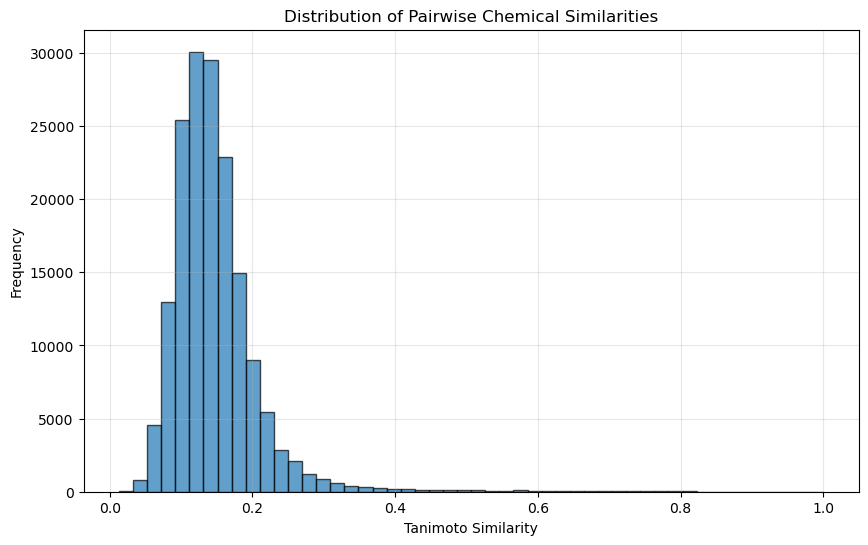

/home/mbelouso/anaconda3/envs/boltz2-tools/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/mbelouso/anaconda3/envs/boltz2-tools/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x1000 with 0 Axes>

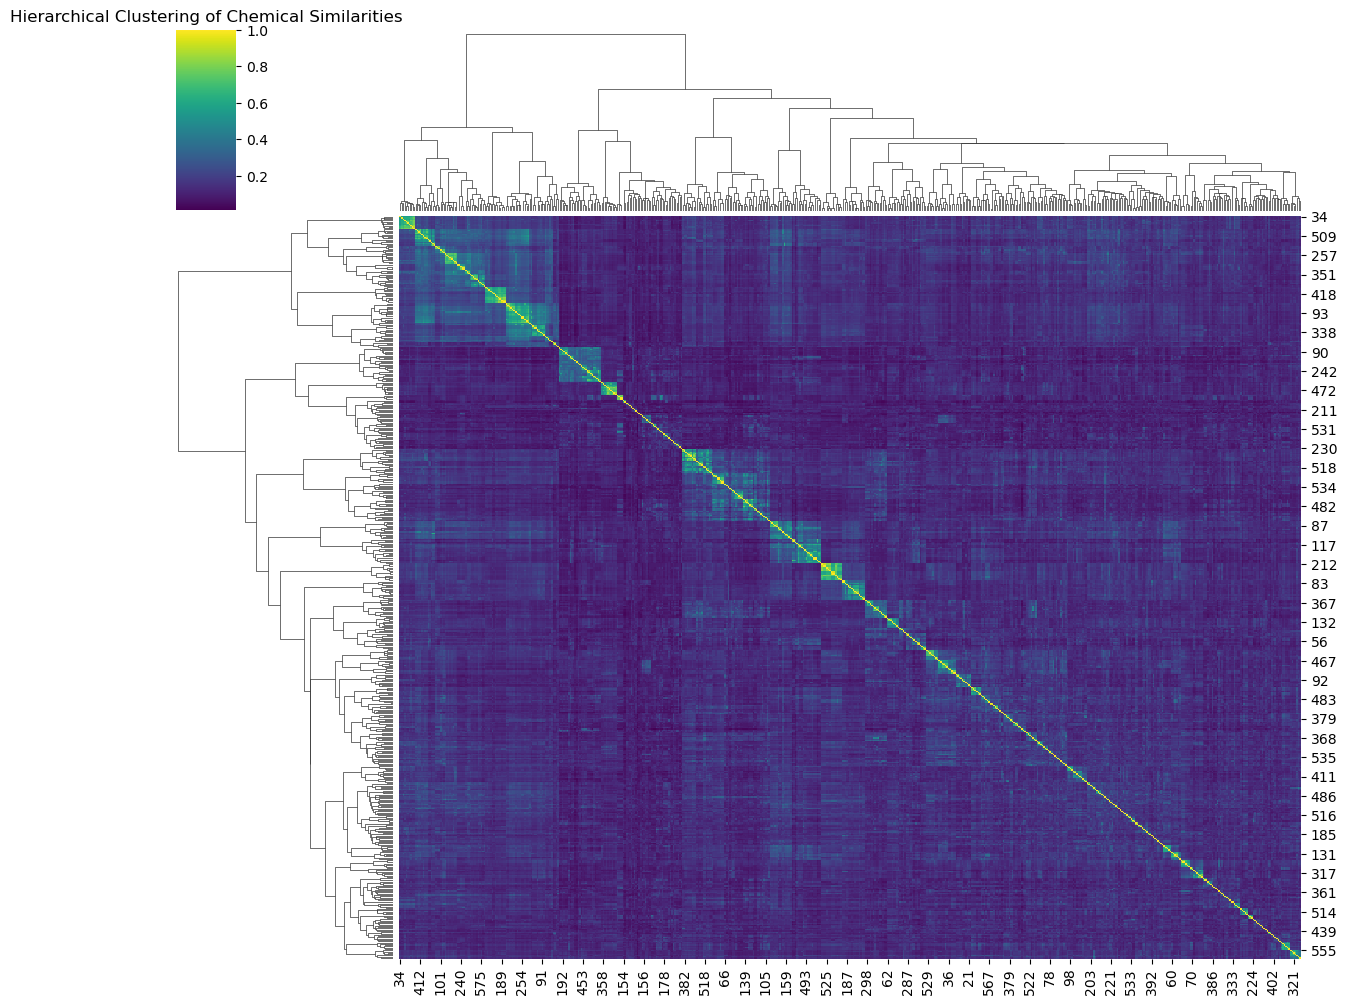

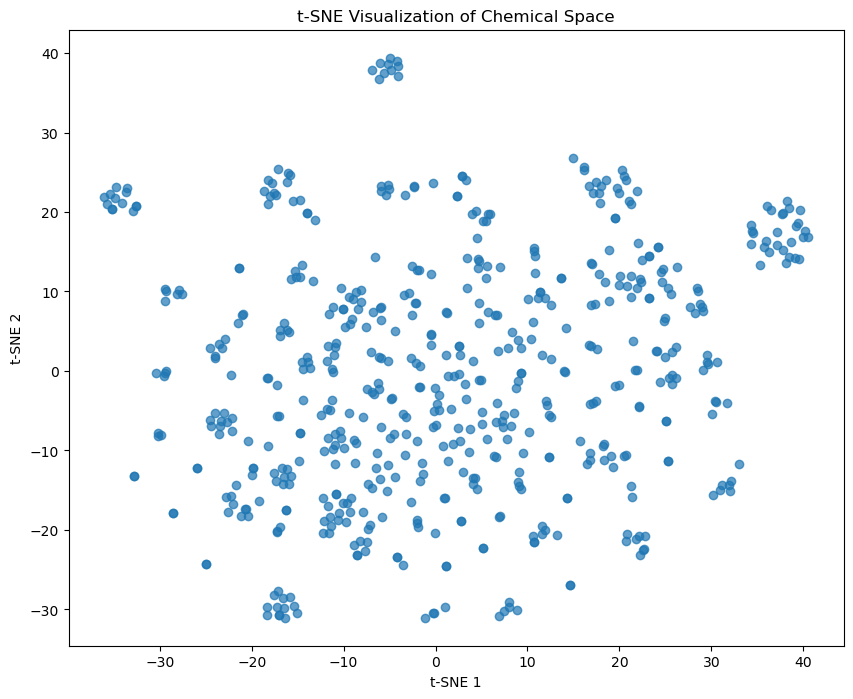

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit import DataStructs
import numpy as np
import matplotlib.pyplot as plt

# Get smiles strings from the dataframe
smiles_list = df['smiles'].dropna().unique().tolist()

# Generate molecular fingerprints
fingerprints = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        fingerprints.append(fp)

# Compute pairwise Tanimoto similarities
n = len(fingerprints)
similarity_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])


# 1. Histogram of similarity values
plt.figure(figsize=(10, 6))
# Get upper triangle of similarity matrix (excluding diagonal)
upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
plt.hist(upper_triangle, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Chemical Similarities')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Clustermap with hierarchical clustering
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.clustermap(similarity_matrix, cmap='viridis', annot=False, 
               figsize=(12, 10), method='ward')
plt.title('Hierarchical Clustering of Chemical Similarities')
plt.show()

# 4. t-SNE dimensionality reduction plot
from sklearn.manifold import TSNE
# Convert fingerprints to numpy array
fp_array = np.array([list(fp) for fp in fingerprints])
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, n-1))
coords = tsne.fit_transform(fp_array)

plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of Chemical Space')
plt.show()

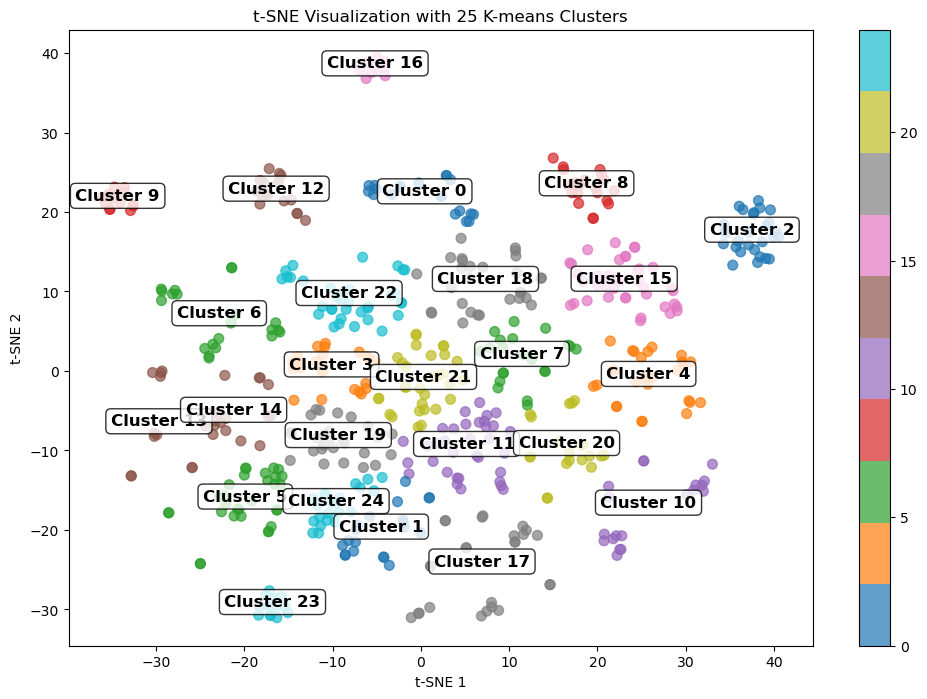

Representative structures for each cluster:

Cluster 0 (Size: 20 molecules):
Representative SMILES: Cc1ccc2c(N3CCN(CCc4cc(F)c5c(c4)NC(=O)CO5)CC3)cccc2n1


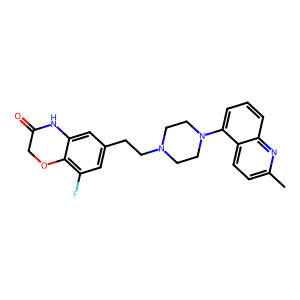


Cluster 1 (Size: 20 molecules):
Representative SMILES: c1ccc2c(c1)OCc1ncccc1C2NC1CN2CCC1CC2


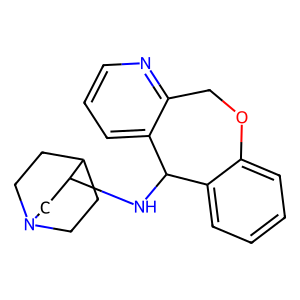


Cluster 2 (Size: 28 molecules):
Representative SMILES: Cc1ccc(NC(=O)CCC(C)NCCc2c[nH]cn2)cc1


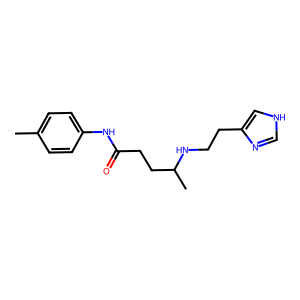


Cluster 3 (Size: 23 molecules):
Representative SMILES: CC(=N)N1C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2


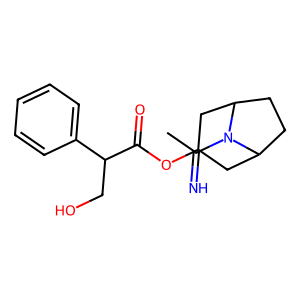


Cluster 4 (Size: 28 molecules):
Representative SMILES: O=S(=O)(c1cccc(C(F)(F)F)c1)c1cccc2oc(N3CCNCC3)nc12


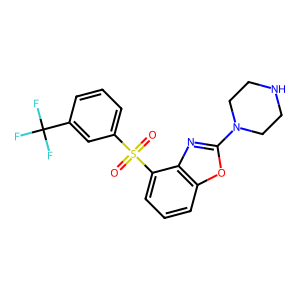


Cluster 5 (Size: 30 molecules):
Representative SMILES: NCCC1CCN(C(=O)[C@](O)(c2ccccc2)C2CCCC2)CC1


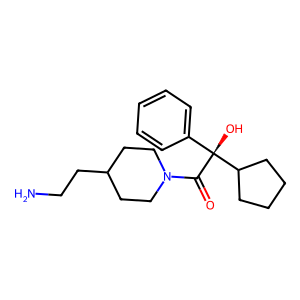


Cluster 6 (Size: 22 molecules):
Representative SMILES: COc1cccc2c1OC(c1ccc(OC3CCN(C4CCC4)CC3)cc1)C(C)S2(=O)=O


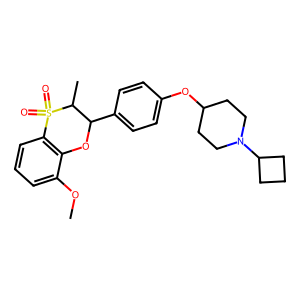


Cluster 7 (Size: 21 molecules):
Representative SMILES: CC(C)NC[C@H](O)COc1cccc(OCCCOc2cccc(OC[C@@H](O)CNC(C)C)c2)c1


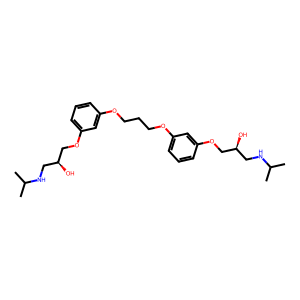


Cluster 8 (Size: 20 molecules):
Representative SMILES: CCN1CCCC(n2cc(S(=O)(=O)c3ccc(Cl)cc3)c3cccnc32)C1


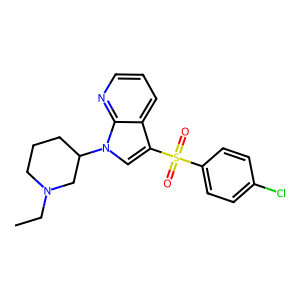


Cluster 9 (Size: 13 molecules):
Representative SMILES: Nc1cc(F)ccc1C(=O)CCCN1CC[C@H]2[C@@H](C1)c1cccc3c1N2CCS3


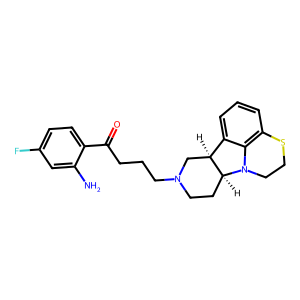


Cluster 10 (Size: 19 molecules):
Representative SMILES: O=C1O[C@]2(CC[C@H](C(=O)Nc3ncc(-c4cccc(F)c4)cn3)CC2)c2cnccc21


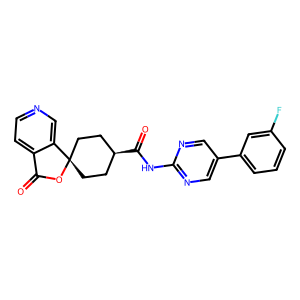


Cluster 11 (Size: 34 molecules):
Representative SMILES: C[C@H]1C2Cc3ccc(C(=O)N(C)C)cc3[C@@]1(C)CCN2CC1CC1


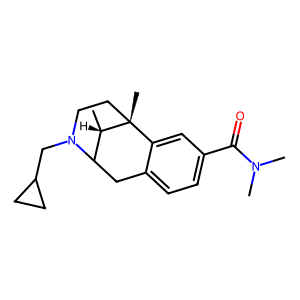


Cluster 12 (Size: 16 molecules):
Representative SMILES: CC(C)n1cc2c3c(cccc31)C1C[C@@H](C(=O)OC3CCC(O)CC3)CN(C)C1C2


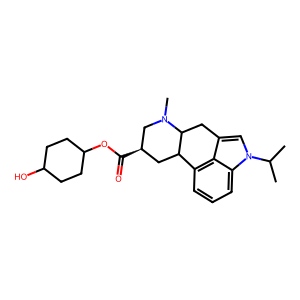


Cluster 13 (Size: 11 molecules):
Representative SMILES: CS(=O)(=O)c1ccc(CN2CCCN(CCC(O)(c3ccccc3)c3cccc(F)c3)CC2)cc1


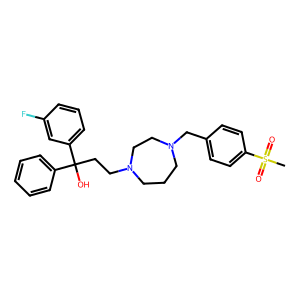


Cluster 14 (Size: 18 molecules):
Representative SMILES: COc1ccc(C2(c3ccc(OC)cc3)CN(C3CCN(Cc4ccccc4)CC3)C(=O)N2)cc1


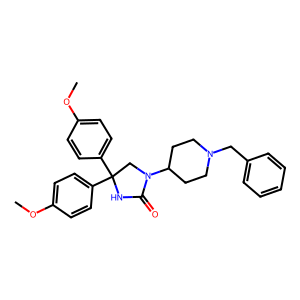


Cluster 15 (Size: 39 molecules):
Representative SMILES: CCN(CC)CCc1cn(S(=O)(=O)c2ccc(N)cc2)c2ccccc12


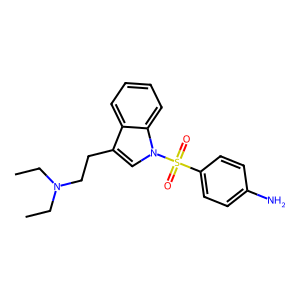


Cluster 16 (Size: 10 molecules):
Representative SMILES: Cc1ncoc1-c1nnc(SCCCN2C[C@@H]3C[C@]3(c3ccc(C(F)(F)F)cc3)C2)n1C


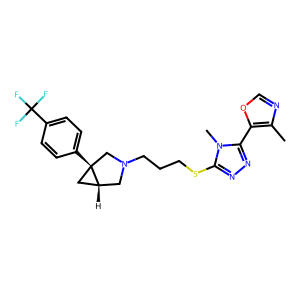


Cluster 17 (Size: 26 molecules):
Representative SMILES: C[C@H]1CN(CCCc2ccsc2)CC[C@@]1(C)c1cccc(O)c1


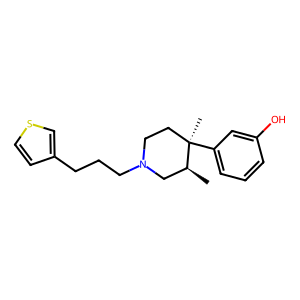


Cluster 18 (Size: 29 molecules):
Representative SMILES: CC(N)Cc1c[nH]c2ccc(OCc3cccs3)cc12


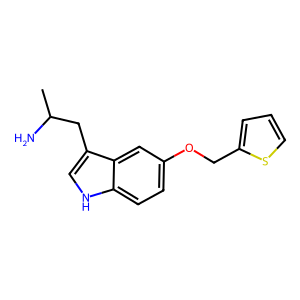


Cluster 19 (Size: 28 molecules):
Representative SMILES: O=C(OC1CCNCC1)C(O)(c1ccccc1)c1ccccc1


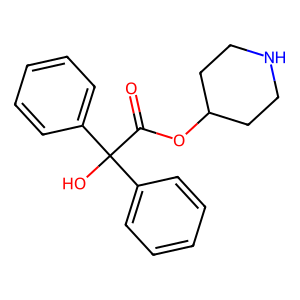


Cluster 20 (Size: 20 molecules):
Representative SMILES: Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1


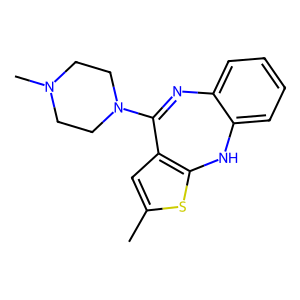


Cluster 21 (Size: 32 molecules):
Representative SMILES: Cc1ccn2cc(-c3ccc(OCCCN4CCCCC4)cc3)cc2c1


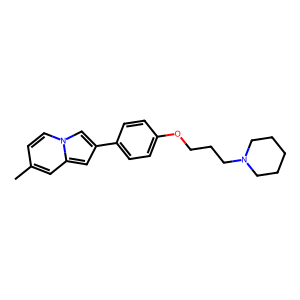


Cluster 22 (Size: 35 molecules):
Representative SMILES: C=CCN1C2CCC1CC(OC(c1ccc(F)cc1)c1ccc(F)cc1)C2


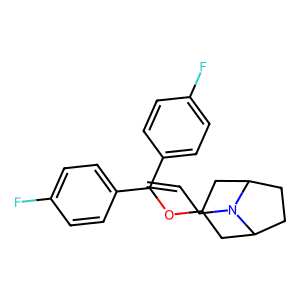


Cluster 23 (Size: 13 molecules):
Representative SMILES: COC1(C#CC(O)(c2ccccc2)c2cncnc2)CN2CCC1CC2


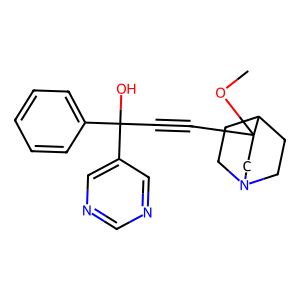


Cluster 24 (Size: 22 molecules):
Representative SMILES: O=C(O[C@H]1CN2CCC1CC2)C(O)(c1ccccc1)c1ccccc1


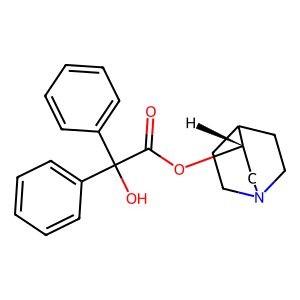


Cluster information saved to 'chemical_clusters.csv'


In [6]:
# 4. K-means clustering on t-SNE coordinates
from sklearn.cluster import KMeans

# Determine optimal number of clusters (you can adjust this)
n_clusters = 25
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(coords)


# Plot t-SNE with cluster colors and labels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=cluster_labels, 
                     cmap='tab10', alpha=0.7, s=50)
plt.colorbar(scatter)

# Add cluster labels at centroid positions
for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    if len(cluster_indices) > 0:
        cluster_coords = coords[cluster_indices]
        centroid = np.mean(cluster_coords, axis=0)
        plt.annotate(f'Cluster {cluster_id}', 
                    xy=centroid, 
                    fontsize=12, 
                    fontweight='bold',
                    ha='center',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f't-SNE Visualization with {n_clusters} K-means Clusters')
plt.show()


# Function to find representative structure for each cluster
def find_cluster_representatives(fingerprints, smiles_list, cluster_labels, coords):
    """
    Find the most representative structure for each cluster.
    Returns the structure closest to the cluster centroid.
    """
    representatives = {}
    
    for cluster_id in range(n_clusters):
        # Get indices of molecules in this cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        if len(cluster_indices) == 0:
            continue
            
        # Get t-SNE coordinates for this cluster
        cluster_coords = coords[cluster_indices]
        
        # Calculate centroid of cluster in t-SNE space
        centroid = np.mean(cluster_coords, axis=0)
        
        # Find molecule closest to centroid
        distances = np.sqrt(np.sum((cluster_coords - centroid)**2, axis=1))
        closest_idx = cluster_indices[np.argmin(distances)]
        
        representatives[cluster_id] = {
            'smiles': smiles_list[closest_idx],
            'index': closest_idx,
            'cluster_size': len(cluster_indices),
            'centroid': centroid
        }
    
    return representatives

# Get representatives for each cluster
cluster_reps = find_cluster_representatives(fingerprints, smiles_list, cluster_labels, coords)

# Display representative structures
from rdkit.Chem import Draw
from IPython.display import display

print("Representative structures for each cluster:")
for cluster_id, rep_info in cluster_reps.items():
    print(f"\nCluster {cluster_id} (Size: {rep_info['cluster_size']} molecules):")
    print(f"Representative SMILES: {rep_info['smiles']}")
    
    # Create molecule image
    mol = Chem.MolFromSmiles(rep_info['smiles'])
    if mol is not None:
        img = Draw.MolToImage(mol, size=(300, 300))
        display(img)

# Save cluster information to DataFrame
cluster_df = pd.DataFrame({
    'smiles': smiles_list,
    'cluster': cluster_labels,
    't_sne_1': coords[:, 0],
    't_sne_2': coords[:, 1]
})

cluster_df.to_csv('chemical_clusters.csv', index=False)
print(f"\nCluster information saved to 'chemical_clusters.csv'")

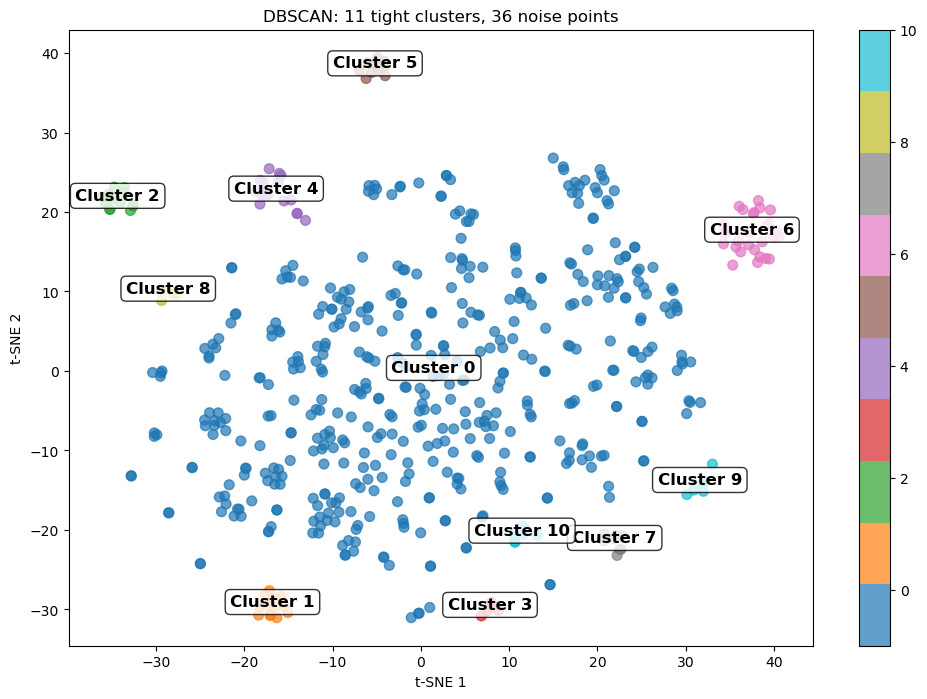

Number of tight clusters: 11
Number of noise points: 36
Representative structures for each cluster:

Cluster 0 (Size: 428 molecules):
Representative SMILES: N=C(NCCCCCN1CCCC1)NCC1CCCCC1


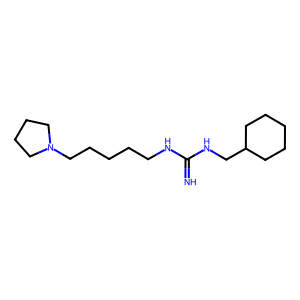


Cluster 1 (Size: 13 molecules):
Representative SMILES: COC1(C#CC(O)(c2ccccc2)c2cncnc2)CN2CCC1CC2


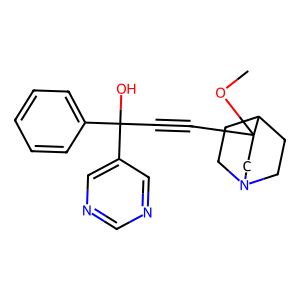


Cluster 2 (Size: 13 molecules):
Representative SMILES: Nc1cc(F)ccc1C(=O)CCCN1CC[C@H]2[C@@H](C1)c1cccc3c1N2CCS3


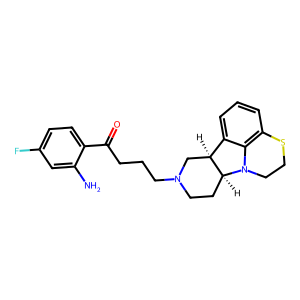


Cluster 3 (Size: 5 molecules):
Representative SMILES: Cc1cc(N2CCN(C)CC2)nc2ccc(NC(=O)COc3ccc(Cl)cc3Cl)cc12


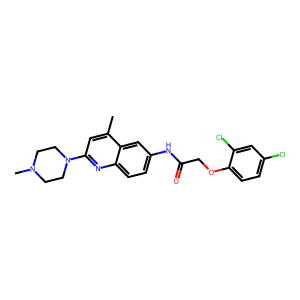


Cluster 4 (Size: 16 molecules):
Representative SMILES: CC(C)n1cc2c3c(cccc31)C1C[C@@H](C(=O)OC3CCC(O)CC3)CN(C)C1C2


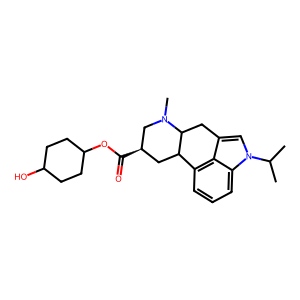


Cluster 5 (Size: 10 molecules):
Representative SMILES: Cc1ncoc1-c1nnc(SCCCN2C[C@@H]3C[C@]3(c3ccc(C(F)(F)F)cc3)C2)n1C


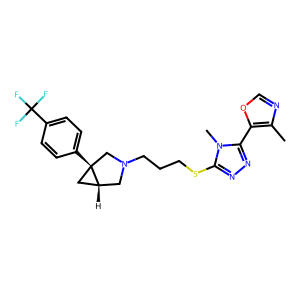


Cluster 6 (Size: 28 molecules):
Representative SMILES: Cc1ccc(NC(=O)CCC(C)NCCc2c[nH]cn2)cc1


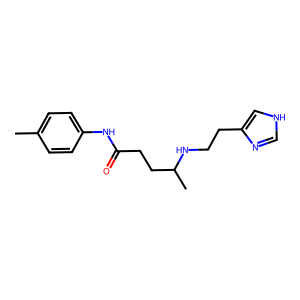


Cluster 7 (Size: 8 molecules):
Representative SMILES: O=C(NCC1CCNCC1)c1c(Cl)cccc1-c1cccc(Cl)c1


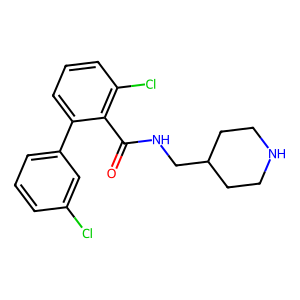


Cluster 8 (Size: 6 molecules):
Representative SMILES: COc1cc(C(C)=O)cc(OC)c1OCCCN1CCC(c2noc3cc(F)ccc23)CC1


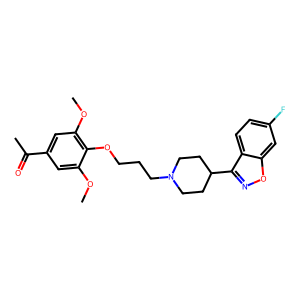


Cluster 9 (Size: 7 molecules):
Representative SMILES: COc1ccc(C2CN(C)Cc3cc(OCCCN4CCN(C(C)C)CC4)ccc32)cc1


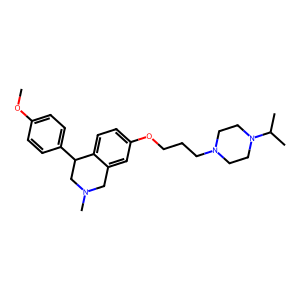


Cluster 10 (Size: 7 molecules):
Representative SMILES: CN1CCN(C2Cc3ccccc3Sc3ccc(CN)cc32)CC1


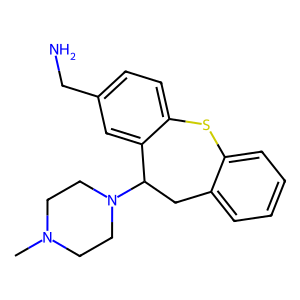


Cluster information saved to 'chemical_clusters.csv'


In [16]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize the t-SNE coordinates
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# DBSCAN clustering - adjust eps and min_samples for tightness
dbscan = DBSCAN(eps=0.25, min_samples=5)  # Lower eps = tighter clusters
cluster_labels = dbscan.fit_predict(coords_scaled)

# Plot results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=cluster_labels, 
                     cmap='tab10', alpha=0.7, s=50)
plt.colorbar(scatter)

# Count clusters (excluding noise points labeled as -1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

# Add cluster labels at centroid positions
unique_clusters = set(cluster_labels)
if -1 in unique_clusters:
    unique_clusters.remove(-1)  # Remove noise points

for cluster_id in unique_clusters:
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    if len(cluster_indices) > 0:
        cluster_coords = coords[cluster_indices]
        centroid = np.mean(cluster_coords, axis=0)
        plt.annotate(f'Cluster {cluster_id}', 
                    xy=centroid, 
                    fontsize=12, 
                    fontweight='bold',
                    ha='center',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f'DBSCAN: {n_clusters} tight clusters, {n_noise} noise points')
plt.show()

print(f"Number of tight clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")



# Function to find representative structure for each cluster
def find_cluster_representatives(fingerprints, smiles_list, cluster_labels, coords):
    """
    Find the most representative structure for each cluster.
    Returns the structure closest to the cluster centroid.
    """
    representatives = {}
    
    for cluster_id in range(n_clusters):
        # Get indices of molecules in this cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        if len(cluster_indices) == 0:
            continue
            
        # Get t-SNE coordinates for this cluster
        cluster_coords = coords[cluster_indices]
        
        # Calculate centroid of cluster in t-SNE space
        centroid = np.mean(cluster_coords, axis=0)
        
        # Find molecule closest to centroid
        distances = np.sqrt(np.sum((cluster_coords - centroid)**2, axis=1))
        closest_idx = cluster_indices[np.argmin(distances)]
        
        representatives[cluster_id] = {
            'smiles': smiles_list[closest_idx],
            'index': closest_idx,
            'cluster_size': len(cluster_indices),
            'centroid': centroid
        }
    
    return representatives

# Get representatives for each cluster
cluster_reps = find_cluster_representatives(fingerprints, smiles_list, cluster_labels, coords)

# Display representative structures
from rdkit.Chem import Draw
from IPython.display import display

print("Representative structures for each cluster:")
for cluster_id, rep_info in cluster_reps.items():
    print(f"\nCluster {cluster_id} (Size: {rep_info['cluster_size']} molecules):")
    print(f"Representative SMILES: {rep_info['smiles']}")
    
    # Create molecule image
    mol = Chem.MolFromSmiles(rep_info['smiles'])
    if mol is not None:
        img = Draw.MolToImage(mol, size=(300, 300))
        display(img)

# Save cluster information to DataFrame
cluster_df = pd.DataFrame({
    'smiles': smiles_list,
    'cluster': cluster_labels,
    't_sne_1': coords[:, 0],
    't_sne_2': coords[:, 1]
})

cluster_df.to_csv('chemical_clusters.csv', index=False)
print(f"\nCluster information saved to 'chemical_clusters.csv'")